## Dependencies

In [1]:
%pip install simpy
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install random2

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the 

In [2]:
import simpy
import numpy as np
import random2 as random
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

# Parameter Definitions

In [3]:
# Operating hours
START_HOUR = 6.0    # 6:00 AM
END_HOUR = 25.5     # 1:30 AM (next day)

# Flow probabilities between areas, these define the probability of a person to go from one area to another
# From Metro
METRO_TO_METRO_PROB = 0.45     # Stay in Metro
METRO_TO_CERCANIAS_PROB = 0.25  # Go to Cercanias
METRO_TO_ENTRANCE_PROB = 0.30   # Go to Entrance

# From Entrance
ENTRANCE_TO_EXIT_PROB = 1.00   # Only for people that have the intention of leaving, not for people generated here.
ENTRANCE_TO_ENTRANCE_PROB = 0.05   # Stay in Entrance
ENTRANCE_TO_METRO_PROB = 0.60     # Go to Metro
ENTRANCE_TO_CERCANIAS_PROB = 0.35 # Go to Cercanias

# From Cercanias
CERCANIAS_TO_CERCANIAS_PROB = 0.02    # Stay in Cercanias
CERCANIAS_TO_METRO_PROB = 0.588       # Go to Metro
CERCANIAS_TO_ENTRANCE_PROB = 0.392    # Go to Entrance

# Mu and Llambda for each area 
# (people per hour / 60 minutes = people per minute)
METRO_1_LAM = 734 / 60 #~14k people per day (both directions)
METRO_2_LAM = 435 / 60 #~8.5k people per day (both directions)
METRO_3_LAM = 350 / 60 #~7k people per day (both directions)
CERCANIAS_LAM = 657 / 60 #~12k people per day (both directions)
ENTRANCE_LAM = 292 / 60 #~6k people per day (entering the station)

METRO_1_MU = 1 / METRO_1_LAM
METRO_2_MU = 1 / METRO_2_LAM
METRO_3_MU = 1 / METRO_3_LAM
CERCANIAS_MU = 1 / CERCANIAS_LAM
ENTRANCE_MU = 1 / ENTRANCE_LAM

# Capacity for each area (people per minute)
METRO_1_CAPACITY = 175 #We assume that metro's arrive every 4 minutes and can take 700 people for two directions
METRO_2_CAPACITY = 175 #We assume that metro's arrive every 4 minutes and can take 700 people for two directions
METRO_3_CAPACITY = 175 #We assume that metro's arrive every 4 minutes and can take 700 people for two directions
CERCANIAS_CAPACITY = 275 #We assume that cercanias arrive every 10 minutes and can take 2.5k people for two directions
ENTRANCE_CAPACITY = 250 #We know that their are a total of 25 turnstiles to enter the station (10 for metro, 15 for cercanias)...
                        # easily 10 people per turnstile per minute

# Simulation time step (in minutes)
STEP_INTERVAL = 10  # Minutes between each flow calculation

## Utils

In [4]:
def is_operating_time(time_in_minutes):
    """Check if the current time is within station operating hours"""
    hour_of_day = (time_in_minutes / 60) % 24
    return (START_HOUR <= hour_of_day < 24.0) or (0 <= hour_of_day < (END_HOUR - 24))

def sim_time_to_time_of_day(sim_time_minutes):
    """Convert simulation time in minutes to hours of day (0-24)"""
    return (sim_time_minutes / 60) % 24

def format_hour_of_day(hour):
    """Format hour as HH:MM in 24-hour time"""
    h = int(hour)
    m = int((hour - h) * 60)
    return f"{h:02d}:{m:02d}"

# Resource Definitions

In [5]:
class Person:
    """Represents a person moving through the station"""
    def __init__(self, env, id, source="Generated", destination=None, leaving=False):
        self.env = env
        self.id = id
        self.entry_time = env.now
        self.source = source
        self.destination = destination
        self.current_area = None
        self.wait_start = None
        self.wait_time = 0  # Total wait time in minutes
        self.leaving = leaving #Flag denoting if someone is on their way out through the Entrance 
        
    def start_waiting(self):
        """Mark the start of waiting time"""
        self.wait_start = self.env.now
        
    def stop_waiting(self):
        """Record the waiting time for an area"""
        if self.wait_start is not None:
            self.wait_time += (self.env.now - self.wait_start)
            self.wait_start = None

class Area:
    """Base class for all areas in the station"""
    def __init__(self, env, name, arrival_rate, service_rate, capacity, station):
        self.env = env
        self.name = name
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.server = simpy.Resource(env, capacity=capacity)
        self.queue_length = []
        self.queue_times = []
        self.people_count = 0
        self.served_count = 0
        self.station = station
        self.server_busy_time = 0
        self.last_state_change = 0
        self.utilization_data = []
        self.people_data = []
        self.generation_data = 0
        self.abandoned_due_to_queue = 0  # number of people who left due to long queues
        
        # Start the arrival process
        if self.arrival_rate > 0:
            self.env.process(self.generate_arrivals())
            
        # Start the metrics collection process
        self.env.process(self.collect_metrics())
        
    def generate_arrivals(self):
        """Generate new people arriving to this area"""
        person_id = 0
        while True:
            # Generate people based on an area's exponential distribution
            interarrival_time = random.expovariate(self.arrival_rate)
            yield self.env.timeout(interarrival_time)
            
            # Check if it's operating hours before generating new people
            current_time = self.env.now
            if not is_operating_time(current_time):
                # Skip generation outside operating hours
                continue
            
            # Create new person
            person_id += 1
            person = Person(self.env, f"{self.name}_{person_id}")
            person.current_area = self.name
            
            # Send to service process
            self.people_count += 1
            self.generation_data += 1
            self.env.process(self.serve_person(person))
            
    def serve_person(self, person):
        """Process a person through this area. Eg. the sink"""
        arrival_time = self.env.now
        
        # Record when person starts waiting
        person.start_waiting()
        
        # Record queue length upon arrival
        queue_len = len(self.server.queue) + 1
        self.queue_length.append(queue_len)
        
        # Check if queue is too long (> 100 people)
        if queue_len > 100 and random.random() < 0.2:  # 20% chance of leaving if queue > 100
            # Person decides to leave the station instead of waiting
            self.abandoned_due_to_queue += 1
            self.people_count -= 1
            
            # If not already in entrance, go to entrance to leave
            if self.name != "Entrance":
                person.current_area = "Entrance"
                person.leaving = True
                self.station.entrance.people_count += 1
                self.env.process(self.station.entrance.serve_person(person))
            else:
                # If already at entrance, exit directly
                self.station.sink.enter(person)
            
            # End this process
            return
        
        # Request service
        with self.server.request() as request:
            yield request
            
            # Mark end of waiting
            person.stop_waiting()
            
            # Record wait time for this area
            wait_time = self.env.now - arrival_time
            self.queue_times.append(wait_time)
            
            # Service time follows exponential distribution
            service_time = random.expovariate(self.service_rate)
            yield self.env.timeout(service_time)
            
            self.served_count += 1
            
            # Determine next destination
            self.people_count -= 1
            self.decide_next_destination(person)
            
    def decide_next_destination(self, person):
        """Determine where the person goes next"""
        # implemented in subclasses
        pass
    
    def collect_metrics(self):
        """Collect metrics on a regular interval"""
        while True:
            yield self.env.timeout(STEP_INTERVAL)
            current_hour = self.env.now / 60
            
            # Utilization = (servers busy + people in queue) / total servers
            # This can exceed 100% if people are generated > they are served
            queue_size = len(self.server.queue)
            busy_servers = self.server.count
            total_utilization = (busy_servers + queue_size) / self.server.capacity * 100
            
            self.utilization_data.append((current_hour, total_utilization))
            self.people_data.append((current_hour, self.people_count))

class Metro(Area):
    def __init__(self, env, station):
        """Initialize the Metro area, and define it as a combination of the distributions of the three lines. 
        This allows us to simplify the system by not having to track People once they are already in the metro (since we'd have to transfer them between lines)
        But it gives us the flexibility to define different arrival rates for each line."""

        self.metro_to_metro_count = 0
        self.total_count = 0

        # Combine all metro arrival rates
        total_metro_arrival_rate = METRO_1_LAM + METRO_2_LAM + METRO_3_LAM
        
        # Use weighted average of service rates
        avg_service_rate = (
            METRO_1_LAM * METRO_1_MU + 
            METRO_2_LAM * METRO_2_MU + 
            METRO_3_LAM * METRO_3_MU
        ) / total_metro_arrival_rate
        
        # Combined capacity
        total_capacity = METRO_1_CAPACITY + METRO_2_CAPACITY + METRO_3_CAPACITY
        
        super().__init__(env, "Metro", total_metro_arrival_rate, avg_service_rate, 
                        total_capacity, station)
    
    def decide_next_destination(self, person):
        """Determine where a person goes after Metro"""
        rand = random.random()
        self.total_count +=1

        # This is our 'router'. According to the probabilities defined in the parameters, we decide where the person goes next
        if rand < METRO_TO_METRO_PROB:
            # Stay in Metro
            self.metro_to_metro_count +=1
            self.station.metro.people_count +=1
            self.env.process(self.serve_person(person))
        elif rand < METRO_TO_METRO_PROB + METRO_TO_CERCANIAS_PROB:
            # Go to Cercanias
            person.current_area = "Cercanias"
            self.station.cercanias.people_count += 1  # Increment count in new area before starting service
            self.env.process(self.station.cercanias.serve_person(person))
        else:
            # Go to Entrance and set leaving flag (this is the only way out of the station, other than being served in Metro or Cercanias).
            # The leaving flag ensures that when people leave a station area to go to the exit, they are not subject to the probabalities of the router again and may be re-routed back into the station
            person.current_area = "Entrance"
            person.leaving = True
            self.station.entrance.people_count += 1  # Increment count in new area before starting service
            self.env.process(self.station.entrance.serve_person(person))

class Cercanias(Area):
    def __init__(self, env, station):
        super().__init__(env, "Cercanias", CERCANIAS_LAM, CERCANIAS_MU, 
                        CERCANIAS_CAPACITY, station)
    
    def decide_next_destination(self, person):
        """Determine where a person goes after Cercanias"""
        rand = random.random()
        
        # This is our 'router'. According to the probabilities defined in the parameters, we decide where the person goes next
        if rand < CERCANIAS_TO_CERCANIAS_PROB:
            # Stay in Cercanias
            self.station.cercanias.people_count += 1
            self.env.process(self.serve_person(person))
        elif rand < CERCANIAS_TO_CERCANIAS_PROB + CERCANIAS_TO_METRO_PROB:
            # Go to Metro
            person.current_area = "Metro"
            self.station.metro.people_count += 1  # Increment count in new area before starting service
            self.env.process(self.station.metro.serve_person(person))
        else:
            # Go to Entrance and set leaving flag
            person.current_area = "Entrance"
            person.leaving = True
            self.station.entrance.people_count += 1  # Increment count in new area before starting service
            self.env.process(self.station.entrance.serve_person(person))

class Entrance(Area):
    def __init__(self, env, station):
        super().__init__(env, "Entrance", ENTRANCE_LAM, ENTRANCE_MU, 
                        ENTRANCE_CAPACITY, station)
        self.exit_count = 0
    
    def decide_next_destination(self, person):
        """Determine where a person goes after Entrance"""
        # If person is leaving, they exit the system BEFORE getting routed again
        if person.leaving:
            self.exit_count += 1
            self.station.sink.enter(person)
            return
        
        # Otherwise determine next destination
        rand = random.random()
        
        if rand < ENTRANCE_TO_ENTRANCE_PROB:
            # Stay in Entrance
            self.station.entrance.people_count += 1
            self.env.process(self.serve_person(person))
        elif rand < ENTRANCE_TO_ENTRANCE_PROB + ENTRANCE_TO_METRO_PROB:
            # Go to Metro
            person.current_area = "Metro"
            self.station.metro.people_count += 1  # Increment count in new area before starting service
            self.env.process(self.station.metro.serve_person(person))
        else:
            # Go to Cercanias
            person.current_area = "Cercanias"
            self.station.cercanias.people_count += 1  # Increment count in new area before starting service
            self.env.process(self.station.cercanias.serve_person(person))

class Sink:
    def __init__(self, env):
        self.env = env
        self.departed = 0
        self.exit_times = []

    def enter(self, person):
        self.departed += 1
        wait_time = person.wait_time
        self.exit_times.append((self.env.now, wait_time))


# Simulation Definition

In [6]:
class StationSimulation:
    def __init__(self, env):
        self.env = env
        self.sink = Sink(env)
        self.hourly_data = defaultdict(lambda: defaultdict(int))

        # collect data per hour for graphs
        self.env.process(self.collect_hourly_metrics())
        
        # Create areas
        self.metro = Metro(env, self)
        self.cercanias = Cercanias(env, self)
        self.entrance = Entrance(env, self)
    
    def collect_hourly_metrics(self):
        """Collect metrics every hour"""
        while True:
            yield self.env.timeout(60)  # Every hour
            
            # Get current hour as index (simulation hour)
            sim_hour = int(self.env.now / 60)
            
            # Get actual time of day (for display purposes)
            hour_of_day = sim_time_to_time_of_day(self.env.now)
            
            print(f"Hour {sim_hour} ({format_hour_of_day(hour_of_day)}): metro {self.metro.people_count} cerc {self.cercanias.people_count} entrance {self.entrance.people_count}")

            self.hourly_data[sim_hour]['metro_count'] = self.metro.people_count
            self.hourly_data[sim_hour]['cercanias_count'] = self.cercanias.people_count
            self.hourly_data[sim_hour]['entrance_count'] = self.entrance.people_count
            self.hourly_data[sim_hour]['total_count'] = (self.metro.people_count + 
                                                       self.cercanias.people_count + 
                                                       self.entrance.people_count)
            self.hourly_data[sim_hour]['exits'] = self.sink.departed
    
    def calculate_metrics(self):
        """Calculate final metrics after simulation"""
        metrics = {}
        
        # Average queue length
        metrics['avg_queue_length_metro'] = np.mean(self.metro.queue_length) if self.metro.queue_length else 0
        metrics['avg_queue_length_cercanias'] = np.mean(self.cercanias.queue_length) if self.cercanias.queue_length else 0
        metrics['avg_queue_length_entrance'] = np.mean(self.entrance.queue_length) if self.entrance.queue_length else 0
        
        # Average queue waiting time
        metrics['avg_wait_time_metro'] = np.mean(self.metro.queue_times) if self.metro.queue_times else 0
        metrics['avg_wait_time_cercanias'] = np.mean(self.cercanias.queue_times) if self.cercanias.queue_times else 0
        metrics['avg_wait_time_entrance'] = np.mean(self.entrance.queue_times) if self.entrance.queue_times else 0
        
        # Server utilization calculation - now can exceed 100%
        if self.metro.utilization_data:
            metrics['utilization_metro'] = np.mean([u[1] for u in self.metro.utilization_data]) / 100
        else:
            metrics['utilization_metro'] = 0
            
        if self.cercanias.utilization_data:
            metrics['utilization_cercanias'] = np.mean([u[1] for u in self.cercanias.utilization_data]) / 100
        else:
            metrics['utilization_cercanias'] = 0
            
        if self.entrance.utilization_data:
            metrics['utilization_entrance'] = np.mean([u[1] for u in self.entrance.utilization_data]) / 100
        else:
            metrics['utilization_entrance'] = 0
        
        # Total counts
        metrics['total_served_metro'] = self.metro.served_count
        metrics['total_served_cercanias'] = self.cercanias.served_count
        metrics['total_served_entrance'] = self.entrance.served_count
        metrics['total_exits'] = self.sink.departed
        
        metrics['total_generated_metro'] = self.metro.generation_data
        metrics['total_generated_cercanias'] = self.cercanias.generation_data
        metrics['total_generated_entrance'] = self.entrance.generation_data
        
        # People who abandoned due to long queues
        metrics['abandoned_metro'] = self.metro.abandoned_due_to_queue
        metrics['abandoned_cercanias'] = self.cercanias.abandoned_due_to_queue
        metrics['abandoned_entrance'] = self.entrance.abandoned_due_to_queue
        metrics['total_abandoned'] = (self.metro.abandoned_due_to_queue + 
                                     self.cercanias.abandoned_due_to_queue + 
                                     self.entrance.abandoned_due_to_queue)
        
        return metrics
    
    def plot_results(self):
        """Plot simulation results"""
        metrics = self.calculate_metrics()
        
        # Convert hourly data to DataFrame
        df = pd.DataFrame.from_dict(self.hourly_data, orient='index')
        
        # Create a figure with multiple subplots
        plt.figure(figsize=(16, 20))
        
        # Plot 1: People count per area over time
        plt.subplot(4, 2, 1)
        
        # Convert indices to time of day
        time_of_day = [(i % 24) for i in df.index]
        x_ticks = range(0, 26, 3)
        x_labels = [format_hour_of_day(h) for h in x_ticks]
        
        plt.plot(time_of_day, df.metro_count, label='Metro')
        plt.plot(time_of_day, df.cercanias_count, label='Cercanias')
        plt.plot(time_of_day, df.entrance_count, label='Entrance')
        plt.plot(time_of_day, df.total_count, label='Total', linestyle='--')
        plt.title('People Count Over Time')
        plt.xlabel('Time of Day (24h)')
        plt.ylabel('Count')
        plt.xticks(np.arange(0, 24, 3), x_labels[0:8])
        plt.legend()
        plt.grid(True)
        
        # Plot 2: Server utilization (can now exceed 100%)
        plt.subplot(4, 2, 2)
        utilization_data = {
            'Metro': metrics['utilization_metro'] * 100,  # Convert back to percentage
            'Cercanias': metrics['utilization_cercanias'] * 100,
            'Entrance': metrics['utilization_entrance'] * 100
        }
        areas = list(utilization_data.keys())
        values = list(utilization_data.values())
        bars = plt.bar(areas, values)
        plt.title('Server Utilization')
        # plt.xlabel('Area')
        plt.ylabel('Utilization (%)')

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f'{yval:.1f}%', ha='center', va='bottom')
        
        # Add a dashed line at 100%
        plt.axhline(y=100, color='r', linestyle='--', label='100% capacity')
        plt.legend()
        plt.grid(True)
        
        # Plot 3: Average queue length
        plt.subplot(4, 2, 3)
        queue_length_data = {
            'Metro': metrics['avg_queue_length_metro'],
            'Cercanias': metrics['avg_queue_length_cercanias'],
            'Entrance': metrics['avg_queue_length_entrance']
        }
        areas = list(queue_length_data.keys())
        values = list(queue_length_data.values())
        plt.bar(areas, values)
        plt.title('Average Queue Length')
        # plt.xlabel('Area')
        plt.ylabel('People')
        plt.grid(True)

        
        # Plot 4: Average waiting time
        plt.subplot(4, 2, 4)
        wait_time_data = {
            'Metro': metrics['avg_wait_time_metro'],
            'Cercanias': metrics['avg_wait_time_cercanias'],
            'Entrance': metrics['avg_wait_time_entrance']
        }
        areas = list(wait_time_data.keys())
        values = list(wait_time_data.values())
        plt.bar(areas, values)
        plt.title('Average Wait Time')
        # plt.xlabel('Area')
        plt.ylabel('Minutes')
        plt.grid(True)

        
        # Plot 5: Total served vs generated per area
        plt.subplot(4, 2, 5)
        areas = ['Metro', 'Cercanias', 'Entrance']
        served_values = [metrics['total_served_metro'], metrics['total_served_cercanias'], metrics['total_served_entrance']]
        generated_values = [metrics['total_generated_metro'], metrics['total_generated_cercanias'], metrics['total_generated_entrance']]
        
        # Set width of bars
        barWidth = 0.3
        
        # Set position of bars on X axis
        r1 = np.arange(len(areas))
        r2 = [x + barWidth for x in r1]
        
        # Create bars
        plt.bar(r1, generated_values, width=barWidth, label='Generated', color='skyblue')
        plt.bar(r2, served_values, width=barWidth, label='Served', color='lightgreen')
        
        # Add labels and legend
        # plt.xlabel('Area')
        plt.ylabel('Count')
        plt.title('Total People Generated vs Served')
        plt.xticks([r + barWidth/2 for r in range(len(areas))], areas)
        plt.legend()
        plt.grid(True)
        
        # Plot 6: Queue length distribution over time for Metro
        plt.subplot(4, 2, 6)
        if len(self.metro.queue_length) > 1:
            # Group queue lengths by hour
            queue_by_hour = {}
            for i, q_len in enumerate(self.metro.queue_length):
                arrival_time = i / len(self.metro.queue_length) * self.env.now / 60  # Approximate arrival hour
                hour = int(arrival_time) % 24  # Convert to 24-hour time
                if hour not in queue_by_hour:
                    queue_by_hour[hour] = []
                queue_by_hour[hour].append(q_len)
            
            # Calculate statistics per hour
            hours = sorted(queue_by_hour.keys())
            metro_means = [np.mean(queue_by_hour[h]) for h in hours]
            metro_maxes = [np.max(queue_by_hour[h]) for h in hours]
            metro_mins = [np.min(queue_by_hour[h]) for h in hours]
            
            plt.fill_between(hours, metro_mins, metro_maxes, alpha=0.3, color='blue')
            plt.plot(hours, metro_means, 'b-', label='Mean')
            plt.plot(hours, metro_maxes, 'b--', label='Max')
            plt.plot(hours, metro_mins, 'b:', label='Min')
            plt.title('Metro Queue Length by Hour')
            plt.xlabel('Time of Day (24h)')
            plt.ylabel('Queue Length')
            plt.xticks(np.arange(0, 24, 3), [format_hour_of_day(h) for h in np.arange(0, 24, 3)])
            plt.legend()
            plt.grid(True)
        else:
            plt.text(0.5, 0.5, 'Insufficient data for Metro queue distribution', 
                    horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        
        # Plot 7: Queue length distribution over time for Cercanias
        plt.subplot(4, 2, 7)
        if len(self.cercanias.queue_length) > 1:
            # Group queue lengths by hour
            queue_by_hour = {}
            for i, q_len in enumerate(self.cercanias.queue_length):
                arrival_time = i / len(self.cercanias.queue_length) * self.env.now / 60
                hour = int(arrival_time) % 24
                if hour not in queue_by_hour:
                    queue_by_hour[hour] = []
                queue_by_hour[hour].append(q_len)
            
            # Calculate statistics per hour
            hours = sorted(queue_by_hour.keys())
            cercanias_means = [np.mean(queue_by_hour[h]) for h in hours]
            cercanias_maxes = [np.max(queue_by_hour[h]) for h in hours]
            cercanias_mins = [np.min(queue_by_hour[h]) for h in hours]
            
            plt.fill_between(hours, cercanias_mins, cercanias_maxes, alpha=0.3, color='green')
            plt.plot(hours, cercanias_means, 'g-', label='Mean')
            plt.plot(hours, cercanias_maxes, 'g--', label='Max')
            plt.plot(hours, cercanias_mins, 'g:', label='Min')
            plt.title('Cercanias Queue Length by Hour')
            plt.xlabel('Time of Day (24h)')
            plt.ylabel('Queue Length')
            plt.xticks(np.arange(0, 24, 3), [format_hour_of_day(h) for h in np.arange(0, 24, 3)])
            plt.legend()
            plt.grid(True)
        else:
            plt.text(0.5, 0.5, 'Insufficient data for Cercanias queue distribution', 
                    horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        
        # Plot 8: Queue length distribution over time for Entrance
        plt.subplot(4, 2, 8)
        if len(self.entrance.queue_length) > 1:
            # Group queue lengths by hour
            queue_by_hour = {}
            for i, q_len in enumerate(self.entrance.queue_length):
                arrival_time = i / len(self.entrance.queue_length) * self.env.now / 60  # Approximate arrival hour
                hour = int(arrival_time) % 24  # Convert to 24-hour time
                if hour not in queue_by_hour:
                    queue_by_hour[hour] = []
                queue_by_hour[hour].append(q_len)
            
            # Calculate statistics per hour
            hours = sorted(queue_by_hour.keys())
            entrance_means = [np.mean(queue_by_hour[h]) for h in hours]
            entrance_maxes = [np.max(queue_by_hour[h]) for h in hours]
            entrance_mins = [np.min(queue_by_hour[h]) for h in hours]
            
            plt.fill_between(hours, entrance_mins, entrance_maxes, alpha=0.3, color='red')
            plt.plot(hours, entrance_means, 'r-', label='Mean')
            plt.plot(hours, entrance_maxes, 'r--', label='Max')
            plt.plot(hours, entrance_mins, 'r:', label='Min')
            plt.title('Entrance Queue Length by Hour')
            plt.xlabel('Time of Day (24h)')
            plt.ylabel('Queue Length')
            plt.xticks(np.arange(0, 24, 3), [format_hour_of_day(h) for h in np.arange(0, 24, 3)])
            plt.legend()
            plt.grid(True)
        else:
            plt.text(0.5, 0.5, 'Insufficient data for Entrance queue distribution', 
                    horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        
        plt.tight_layout()
        plt.savefig('station_simulation_results.png')
        
        # Create a second figure for wait time distributions
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Wait time distribution for Metro
        plt.subplot(2, 2, 1)
        if len(self.metro.queue_times) > 1:
            # Group wait times by hour
            wait_by_hour = {}
            for i, wait_time in enumerate(self.metro.queue_times):
                # Approximate the hour based on index position
                arrival_time = i / len(self.metro.queue_times) * self.env.now / 60
                hour = int(arrival_time) % 24  # Convert to 24-hour time
                if hour not in wait_by_hour:
                    wait_by_hour[hour] = []
                wait_by_hour[hour].append(wait_time)
            
            # Calculate statistics per hour
            hours = sorted(wait_by_hour.keys())
            metro_means = [np.mean(wait_by_hour[h]) for h in hours]
            metro_maxes = [np.max(wait_by_hour[h]) for h in hours]
            metro_mins = [np.min(wait_by_hour[h]) for h in hours]
            
            plt.fill_between(hours, metro_mins, metro_maxes, alpha=0.3, color='blue')
            plt.plot(hours, metro_means, 'b-', label='Mean')
            plt.plot(hours, metro_maxes, 'b--', label='Max')
            plt.plot(hours, metro_mins, 'b:', label='Min')
            plt.title('Metro Wait Time by Hour')
            plt.xlabel('Time of Day (24h)')
            plt.ylabel('Wait Time (minutes)')
            plt.xticks(np.arange(0, 24, 3), [format_hour_of_day(h) for h in np.arange(0, 24, 3)])
            plt.legend()
            plt.grid(True)
        else:
            plt.text(0.5, 0.5, 'Insufficient data for Metro wait time distribution', 
                    horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        
        # Plot 2: Wait time distribution for Cercanias
        plt.subplot(2, 2, 2)
        if len(self.cercanias.queue_times) > 1:
            # Group wait times by hour
            wait_by_hour = {}
            for i, wait_time in enumerate(self.cercanias.queue_times):
                # Approximate the hour based on index position
                arrival_time = i / len(self.cercanias.queue_times) * self.env.now / 60
                hour = int(arrival_time) % 24  # Convert to 24-hour time
                if hour not in wait_by_hour:
                    wait_by_hour[hour] = []
                wait_by_hour[hour].append(wait_time)
            
            # Calculate statistics per hour
            hours = sorted(wait_by_hour.keys())
            cercanias_means = [np.mean(wait_by_hour[h]) for h in hours]
            cercanias_maxes = [np.max(wait_by_hour[h]) for h in hours]
            cercanias_mins = [np.min(wait_by_hour[h]) for h in hours]
            
            plt.fill_between(hours, cercanias_mins, cercanias_maxes, alpha=0.3, color='green')
            plt.plot(hours, cercanias_means, 'g-', label='Mean')
            plt.plot(hours, cercanias_maxes, 'g--', label='Max')
            plt.plot(hours, cercanias_mins, 'g:', label='Min')
            plt.title('Cercanias Wait Time by Hour')
            plt.xlabel('Time of Day (24h)')
            plt.ylabel('Wait Time (minutes)')
            plt.xticks(np.arange(0, 24, 3), [format_hour_of_day(h) for h in np.arange(0, 24, 3)])
            plt.legend()
            plt.grid(True)
        else:
            plt.text(0.5, 0.5, 'Insufficient data for Cercanias wait time distribution', 
                    horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        
        # Plot 3: Wait time distribution for Entrance
        plt.subplot(2, 2, 3)
        if len(self.entrance.queue_times) > 1:
            # Group wait times by hour
            wait_by_hour = {}
            for i, wait_time in enumerate(self.entrance.queue_times):
                # Approximate the hour based on index position
                arrival_time = i / len(self.entrance.queue_times) * self.env.now / 60
                hour = int(arrival_time) % 24  # Convert to 24-hour time
                if hour not in wait_by_hour:
                    wait_by_hour[hour] = []
                wait_by_hour[hour].append(wait_time)
            
            # Calculate statistics per hour
            hours = sorted(wait_by_hour.keys())
            entrance_means = [np.mean(wait_by_hour[h]) for h in hours]
            entrance_maxes = [np.max(wait_by_hour[h]) for h in hours]
            entrance_mins = [np.min(wait_by_hour[h]) for h in hours]
            
            plt.fill_between(hours, entrance_mins, entrance_maxes, alpha=0.3, color='red')
            plt.plot(hours, entrance_means, 'r-', label='Mean')
            plt.plot(hours, entrance_maxes, 'r--', label='Max')
            plt.plot(hours, entrance_mins, 'r:', label='Min')
            plt.title('Entrance Wait Time by Hour')
            plt.xlabel('Time of Day (24h)')
            plt.ylabel('Wait Time (minutes)')
            plt.xticks(np.arange(0, 24, 3), [format_hour_of_day(h) for h in np.arange(0, 24, 3)])
            plt.legend()
            plt.grid(True)
        else:
            plt.text(0.5, 0.5, 'Insufficient data for Entrance wait time distribution', 
                    horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        
        # Plot 4: Combined wait time comparison
        plt.subplot(2, 2, 4)
        if all(len(area.queue_times) > 1 for area in [self.metro, self.cercanias, self.entrance]):
            # Get mean wait times for each area by hour
            metro_hours = sorted(wait_by_hour.keys())
            cercanias_hours = sorted(wait_by_hour.keys())
            entrance_hours = sorted(wait_by_hour.keys())
            
            # Use a common set of hours for all areas
            common_hours = sorted(set(metro_hours) & set(cercanias_hours) & set(entrance_hours))
            
            if common_hours:
                # Plot mean wait times for each area
                plt.plot(common_hours, [np.mean(wait_by_hour.get(h, [0])) for h in common_hours], 'b-', label='Metro')
                plt.plot(common_hours, [np.mean(wait_by_hour.get(h, [0])) for h in common_hours], 'g-', label='Cercanias')
                plt.plot(common_hours, [np.mean(wait_by_hour.get(h, [0])) for h in common_hours], 'r-', label='Entrance')
                plt.title('Mean Wait Time Comparison by Hour')
                plt.xlabel('Time of Day (24h)')
                plt.ylabel('Wait Time (minutes)')
                plt.xticks(np.arange(0, 24, 3), [format_hour_of_day(h) for h in np.arange(0, 24, 3)])
                plt.legend()
                plt.grid(True)
            else:
                plt.text(0.5, 0.5, 'Insufficient common hours for wait time comparison', 
                        horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        else:
            plt.text(0.5, 0.5, 'Insufficient data for wait time comparison', 
                    horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        
        plt.tight_layout()
        plt.savefig('station_wait_time_distributions.png')
        plt.show()
        
        # Print summary metrics
        print("\nSimulation Summary Metrics:")
        print(f"Total people served - Metro: {metrics['total_served_metro']}")
        print(f"Total people served - Cercanias: {metrics['total_served_cercanias']}")
        print(f"Total people served - Entrance: {metrics['total_served_entrance']}")
        print(f"Total exits: {metrics['total_exits']}")
        print(f"Average queue length - Metro: {metrics['avg_queue_length_metro']:.2f}")
        print(f"Average queue length - Cercanias: {metrics['avg_queue_length_cercanias']:.2f}")
        print(f"Average queue length - Entrance: {metrics['avg_queue_length_entrance']:.2f}")
        print(f"Average wait time - Metro: {metrics['avg_wait_time_metro']:.2f} minutes")
        print(f"Average wait time - Cercanias: {metrics['avg_wait_time_cercanias']:.2f} minutes")
        print(f"Average wait time - Entrance: {metrics['avg_wait_time_entrance']:.2f} minutes")
        print(f"Server utilization - Metro: {metrics['utilization_metro']:.2%}")
        print(f"Server utilization - Cercanias: {metrics['utilization_cercanias']:.2%}")
        print(f"Server utilization - Entrance: {metrics['utilization_entrance']:.2%}")
        print(f"Total people generated - Metro: {metrics['total_generated_metro']}")
        print(f"Total people generated - Cercanias: {metrics['total_generated_cercanias']}")
        print(f"Total people generated - Entrance: {metrics['total_generated_entrance']}")
        print("\nUnexpected Behavior Metrics:")
        print(f"People who abandoned due to long queues - Metro: {metrics['abandoned_metro']}")
        print(f"People who abandoned due to long queues - Cercanias: {metrics['abandoned_cercanias']}")
        print(f"People who abandoned due to long queues - Entrance: {metrics['abandoned_entrance']}")
        print(f"Total abandonments: {metrics['total_abandoned']}")

### Running the simulation

Hour 1 (01:00): metro 659 cerc 310 entrance 206
Hour 2 (02:00): metro 232 cerc 148 entrance 72
Hour 3 (03:00): metro 31 cerc 11 entrance 10
Hour 4 (04:00): metro 1 cerc 1 entrance 1
Hour 5 (05:00): metro 0 cerc 0 entrance 0
Hour 6 (06:00): metro 0 cerc 0 entrance 0
Hour 7 (07:00): metro 611 cerc 376 entrance 192
Hour 8 (08:00): metro 624 cerc 421 entrance 200
Hour 9 (09:00): metro 631 cerc 372 entrance 236
Hour 10 (10:00): metro 628 cerc 400 entrance 194
Hour 11 (11:00): metro 628 cerc 372 entrance 232
Hour 12 (12:00): metro 623 cerc 369 entrance 234
Hour 13 (13:00): metro 631 cerc 374 entrance 207
Hour 14 (14:00): metro 628 cerc 349 entrance 269
Hour 15 (15:00): metro 623 cerc 383 entrance 229
Hour 16 (16:00): metro 621 cerc 384 entrance 227
Hour 17 (17:00): metro 619 cerc 374 entrance 239
Hour 18 (18:00): metro 625 cerc 386 entrance 207
Hour 19 (19:00): metro 627 cerc 371 entrance 239
Hour 20 (20:00): metro 626 cerc 375 entrance 222
Hour 21 (21:00): metro 622 cerc 378 entrance 209
Ho

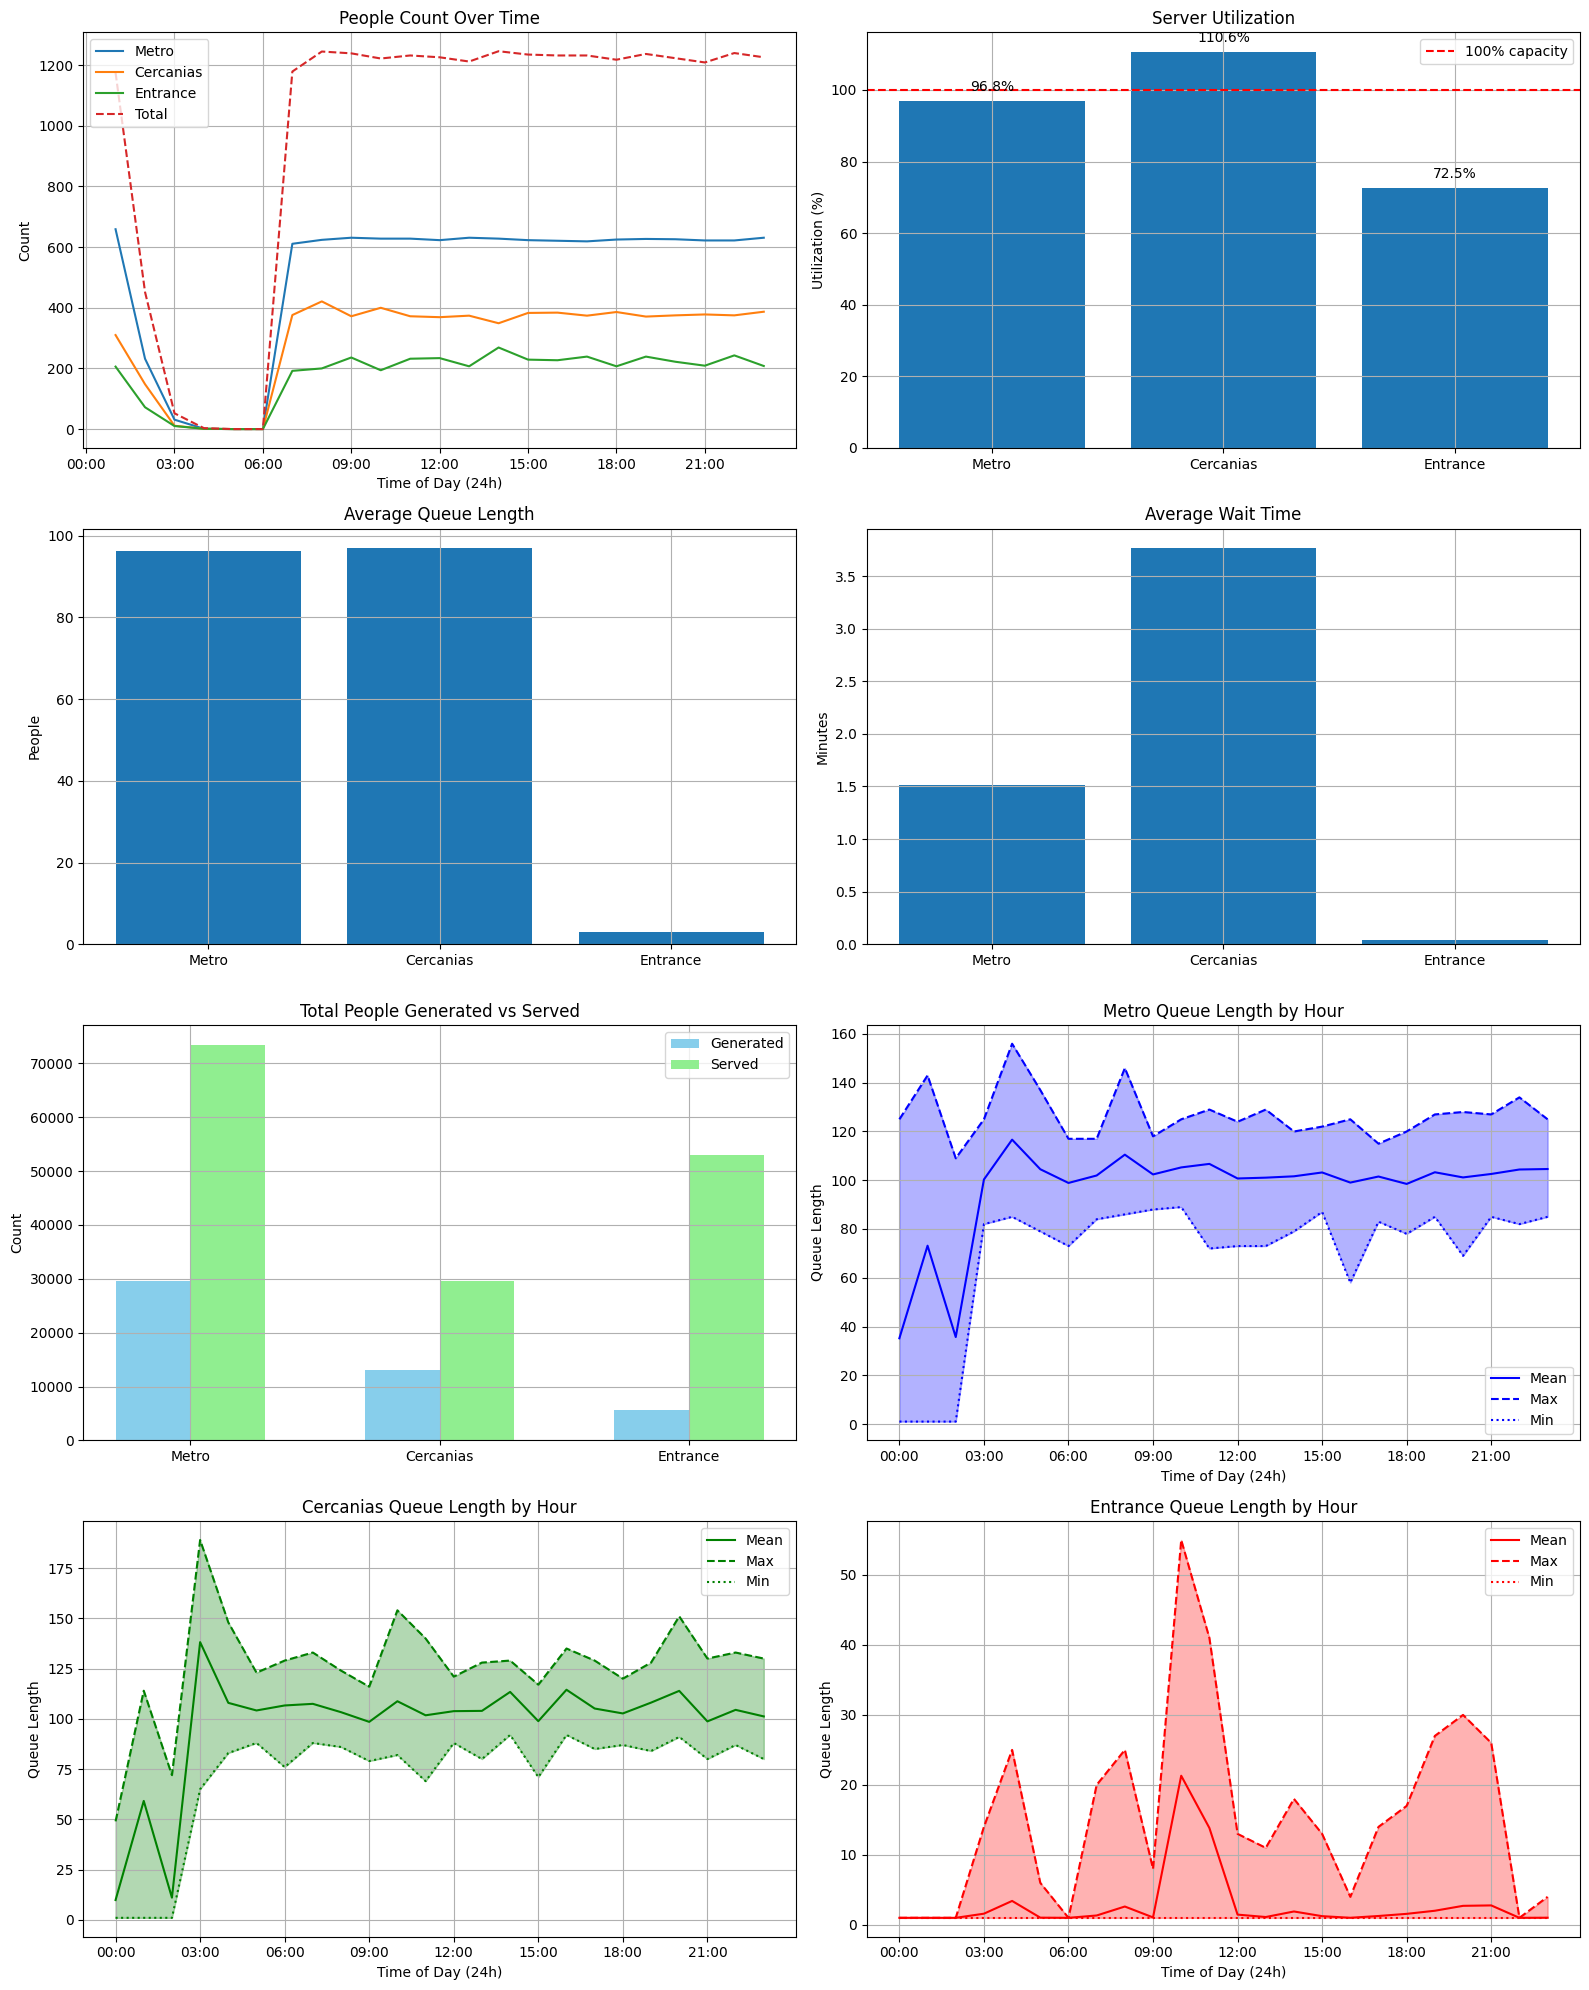

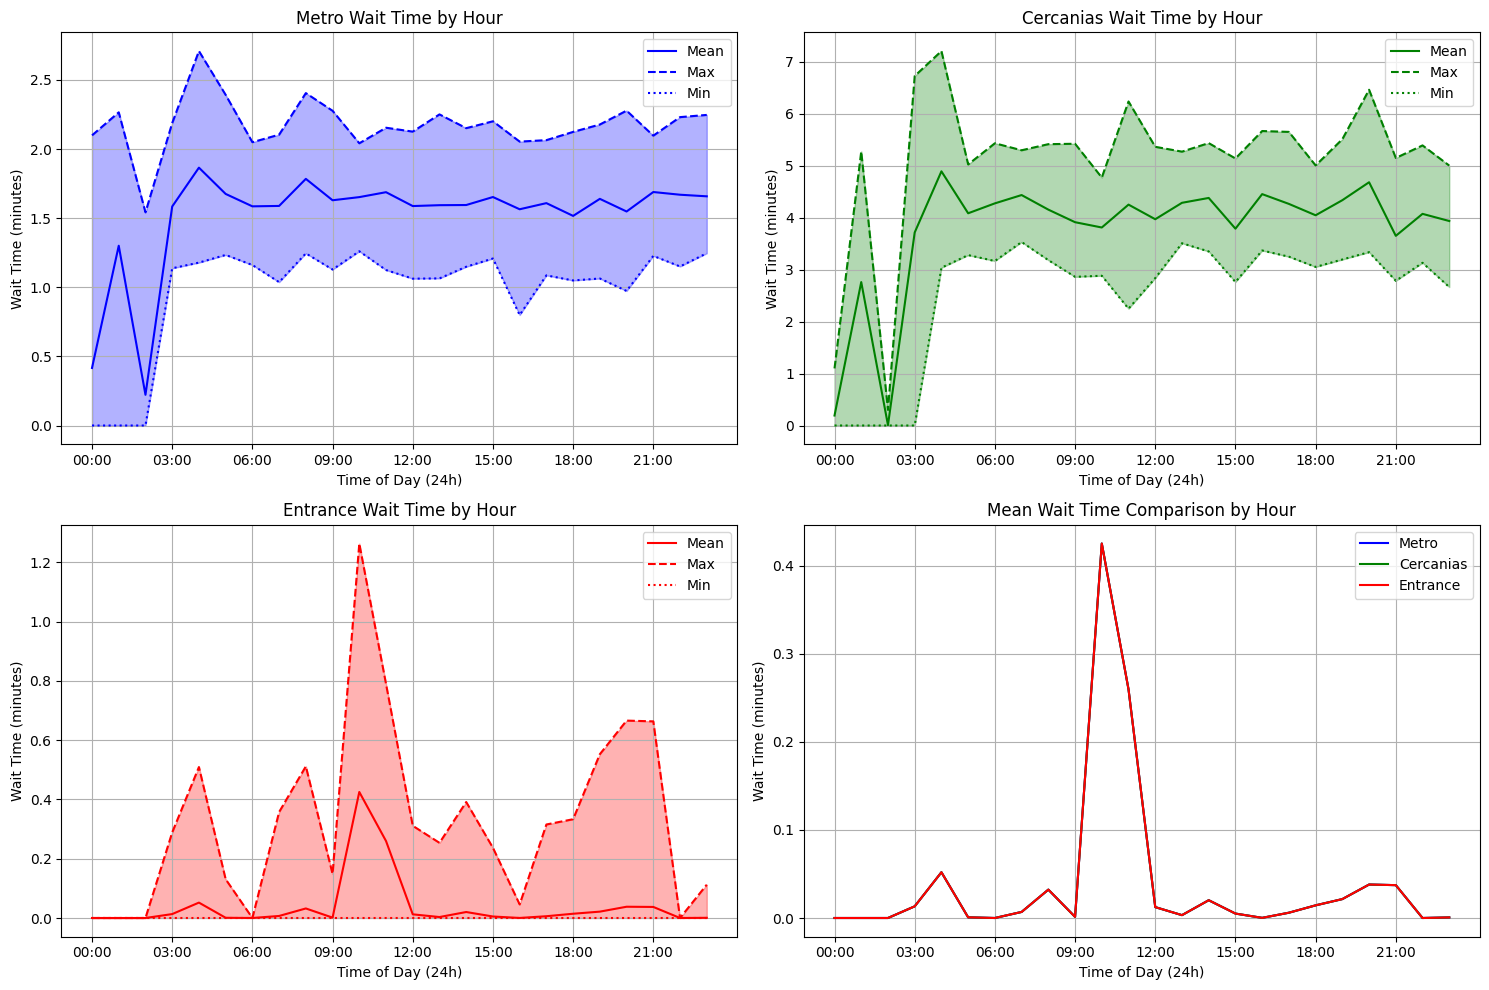


Simulation Summary Metrics:
Total people served - Metro: 73466
Total people served - Cercanias: 29671
Total people served - Entrance: 52981
Total exits: 47002
Average queue length - Metro: 96.37
Average queue length - Cercanias: 96.90
Average queue length - Entrance: 2.89
Average wait time - Metro: 1.51 minutes
Average wait time - Cercanias: 3.76 minutes
Average wait time - Entrance: 0.04 minutes
Server utilization - Metro: 96.78%
Server utilization - Cercanias: 110.56%
Server utilization - Entrance: 72.51%
Total people generated - Metro: 29514
Total people generated - Cercanias: 12995
Total people generated - Entrance: 5691

Unexpected Behavior Metrics:
People who abandoned due to long queues - Metro: 9454
People who abandoned due to long queues - Cercanias: 4060
People who abandoned due to long queues - Entrance: 0
Total abandonments: 13514


In [7]:
def run_simulation(sim_duration=24*60):
    """Run the simulation for the specified duration in minutes"""
    # Create SimPy environment
    env = simpy.Environment()
    
    # Create and run simulation
    simulation = StationSimulation(env)
    
    # Run for specified duration (minutes)
    env.run(until=sim_duration)
    
    # Plot results
    simulation.plot_results()
    
    return simulation

run_simulation(1440)